In [1]:
from __future__ import division
from covertrace.data_array import Sites
from functools import partial
import matplotlib.pyplot as plt
import numpy as np
import os
from os.path import abspath, dirname, join
from scipy.integrate import odeint
from scipy.optimize import minimize
import seaborn as sns
%matplotlib inline

In [2]:
from covertrace.utils.kinase_estimation_inh import fit_params_inhibitor
from covertrace.utils.kinase_estimation_dynamics import fit_trapezoid

In [3]:
from covertrace import ops_filter
from covertrace import ops_plotter
from covertrace import ops_bool

In [4]:
data_folder = join(dirname(dirname(dirname(abspath(os.curdir)))), 'covertrackdev', 'output')

## Parameters from literature

r<sub>total</sub>, k<sub>cat</sub> and K<sub>m</sub> are taken from the previous works. 

In [5]:
r_total = 0.4  # uM
k_cat = 20.0  # 1/min
Km = 3.0  # uM

## Estimation of cytosolic to nuclear volume ratio: k<sub>v</sub>

First obtain the parameter k<sub>v</sub>, ratio of cytosolic volume to nuclear volume. 

Since total reporter concentration is constant at a time scale of our experiments,  
$r_{c,1} + \dfrac{r_{n,1}}{k_v} = r_{c,2} + \dfrac{r_{n,2}}{k_v}$ where $r_{c,i}$ and $r_{n,i}$ are the cytosolic and nuclear concentrations of the reporter in condition *i*.  
Solving for $k_v$, we get  
$k_v = \dfrac{r_{n,2} - r_{n,1}}{r_{c,1} - r_{c,2}}$.  
Larger dynamic range will give you a better estimation of $k_v$ due to the measurement noise.  Thus, we use the condition where JNK reporter is activated by anisomycin and then inhibited by JNK inhibitor. 

In [6]:
parent_folder = join(data_folder, 'AnisoInh')
sub_folders = ['Pos001', 'Pos002']
conditions = ['AnisoInh', 'AnisoInh']
sites = Sites(parent_folder, sub_folders, conditions, file_name='df_cleaned.npz')
# Merge cells from two sites.
sites.merge_conditions()

Pos001: file_name is updated to arr_modified.npz


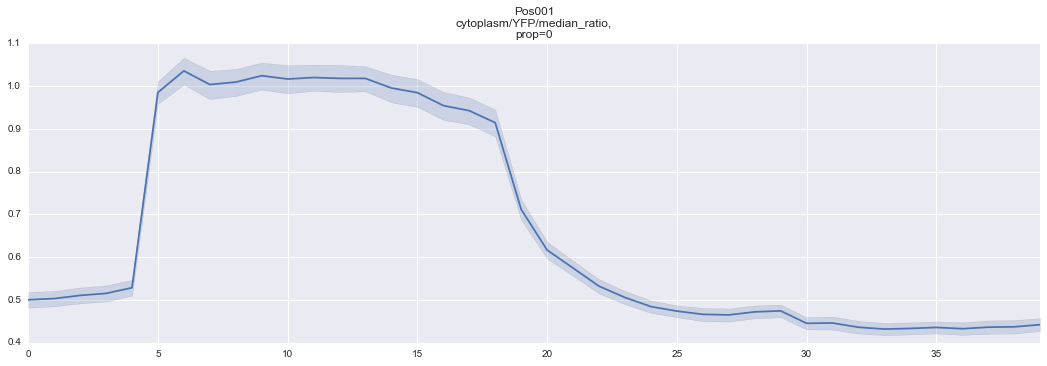

In [7]:
# Take a look at average traces for the cytoplasmic/nuclear ratio of median intensity. This is the cleaned dataset.
sites.set_state(['cytoplasm', 'YFP', 'median_ratio'])
plot_tsplot = partial(ops_plotter.plot_tsplot)
fig, axes = sites.iterate(plot_tsplot)

You see the cytoplasmic translocation of JNK KTR at frame 5 when cells are stimulated at anisomycin and 
then nuclear translocation at frame 18 when they are inhibited with JNK IVV inhibitor.  
This combination of activation and inactivation will provide a large dynamic range, helping robust parameter estimation. 

Again, we use $k_v = \dfrac{r_{n,2} - r_{n,1}}{r_{c,1} - r_{c,2}}$ for getting $k_v$.  
Let's take frame 7 and frame 35 for two conditions. 


In [8]:
site = sites.Pos001
idx_condition_1 = 7
idx_condition_2 = 35
r_n_1 = np.nanmedian(site.data['nuclei', 'YFP', 'median_intensity'][:, idx_condition_1])
r_n_2 = np.nanmedian(site.data['nuclei', 'YFP', 'median_intensity'][:, idx_condition_2])
r_c_1 = np.nanmedian(site.data['cytoplasm', 'YFP', 'median_intensity'][:, idx_condition_1])
r_c_2 = np.nanmedian(site.data['cytoplasm', 'YFP', 'median_intensity'][:, idx_condition_2])
estimated_k_v = (r_n_2 - r_n_1)/(r_c_1 - r_c_2)
print estimated_k_v

3.1496350365


## Estimation of import and export rate constants: k<sub>iu</sub>, k<sub>eu</sub>, k<sub>ip</sub>, k<sub>ep</sub>

The cytoplasmic translocation of KTR happens because phosphorylation decreases the export rate and increases
the import rate. Thus we would like to know the import and export rate constants for both phosphorylated reporters and 
non-phosphorylated reporters. 
To estimate these constants, we utilize the fact that JNK KTR AA and JNK KTR EE mutants approximate the unphosphorylated 
and phosphorylated state of the wild-type JNK KTR, respectively. 

In [9]:
parent_folder_mut = join(data_folder, 'LMB')
sub_folders_mut = ['Pos003', 'Pos004', 'Pos005', 'Pos005']
conditions_mut = ['JNK_AA', 'JNK_AA', 'JNK_EE', 'JNK_EE']
sites_mut = Sites(parent_folder_mut, sub_folders_mut, conditions_mut, file_name='df_cleaned.npz')
sites_mut.merge_conditions()

Pos003: file_name is updated to arr_modified.npz


Leptomycin B was added at frame 3 and you see a decrease of export led to the nuclear translocation.

[<matplotlib.text.Text at 0x111a8fb10>, <matplotlib.text.Text at 0x111dff5d0>]

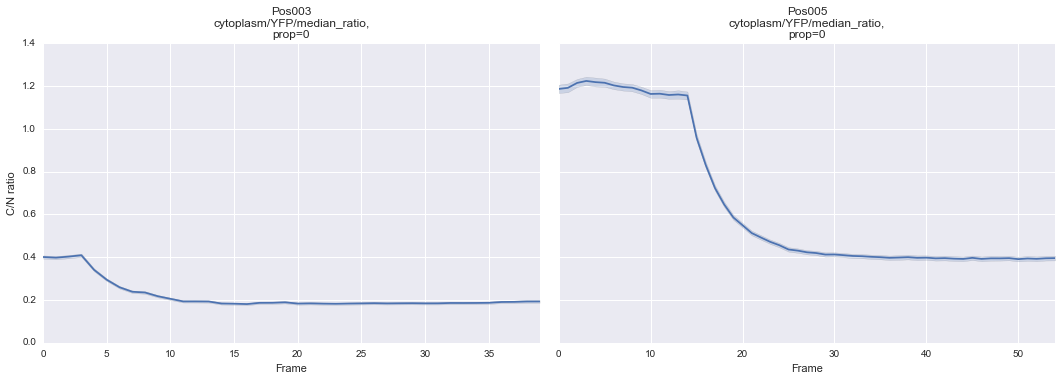

In [10]:
sites_mut.set_state(['cytoplasm', 'YFP', 'median_ratio'])
fig, axes = sites_mut.iterate(plot_tsplot)
axes[0].set_ylabel('C/N ratio')
[ax.set_xlabel('Frame') for ax in axes]

In [11]:
aa_ratio = sites_mut.Pos003.data['cytoplasm', 'YFP', 'median_ratio']
ee_ratio = sites_mut.Pos005.data['cytoplasm', 'YFP', 'median_ratio']

Efficiency of inhibition varies from cell-to-cell. This is expressed by parameter $h$; upon inhibition at time *t<sub>inh</sub>*, export rate changes from $k_e$ to $hk_e$.  
Since phosphorylation does not happen to these mutants, we assume k<sub>e/i</sub> for AA mutants as k<sub>eu/iu</sub> and k<sub>e/i</sub> for EE mutants as k<sub>ep/ip</sub>.
This will give you a following system to decribe a reporter concentration in nucleus (r<sub>n</sub>) and cytoplasm (r<sub>c</sub>).

$\dfrac{dr_c}{dt} = -k_i  r_c + k_e  r_n$  
$\dfrac{dr_n}{dt} = k_v  k_i  r_c - k_v  k_e  r_n$

In [12]:
# Describe this system as ODE
def ode_mutant_model(y, t, *args):
    k_v, k_i, k_e = args[0], args[1], args[2]
    r_c, r_n = y[0], y[1]
    d_r_c = -k_i * r_c + k_e * r_n
    d_r_n = k_v * k_i * r_c - k_v * k_e * r_n
    return [d_r_c, d_r_n]

The initial steady state of the system is $\dfrac{k_e}{k_i}$, and the steady state after the inhibition will be $\dfrac{hk_e}{k_i}$. 
For each cells, estimate *h*. 

In [13]:
# h can be calculated based on steady states at the beginning and at the end. 
h_aa, h_ee = [], []
for cell in aa_ratio:
    h_aa.append(np.mean(cell[30:])/np.mean(cell[:3]))
for cell in ee_ratio:
    h_ee.append(np.mean(cell[30:])/np.mean(cell[10:13]))

We would like to find the parameters $h$, $k_e$ and $k_i$ such that the model reproduces the time sereis of LMB treatment experiment. Write a function that receives $h$, $k_e$ and $k_i$ and returns the predicted time course of C/N ratio.

In [14]:
# define a wrapper function that receives time, k_e, k_i and h to run a simulation. 
def calc_ts_sim_ratio(x, time, k_v, t_inh, h):
    ei_ratio = x[0]
    k_i = x[1]
    k_e = ei_ratio * k_i
    
    ini_r_c = 1.0
    ini_r_n = 1.0/ei_ratio
    params = (k_v, k_i, k_e)
    # Simulate before inhibition
    ts_pre_inh = odeint(ode_mutant_model, [ini_r_c, ini_r_n], time[time<t_inh], params, rtol=1e-4)
    r_pre_inh = np.array([i[0]/i[1] for i in ts_pre_inh])  # convert reporter profile to cytoplasmic/nuclear ratio
    params = (k_v, k_i, k_e * h)
    # Simulate after inhibition
    ts_post_inh = odeint(ode_mutant_model, [ts_pre_inh[-1, 0], ts_pre_inh[-1, 1]], time[time>=t_inh], params, rtol=1e-4)
    r_post_inh = np.array([i[0]/i[1] for i in ts_post_inh])  # convert reporter profile to cytoplasmic/nuclear ratio
    return np.concatenate((r_pre_inh, r_post_inh))

To begin with, run a simulation just for a single cell in EE mutants.  
Since EE mutants reaches to the steady around frame 30, we will simulate the decay from frame 0 to frame 30.  
Before the stimulation, $\dfrac{k_e}{k_i} = \dfrac{r_c}{r_n}$.

In [15]:
bnds = ((1e-6, None), (1e-6, None))  # boundary for h, k_i and k_e
time_ee = np.concatenate((np.arange(0, 28, 2), np.arange(28, 48.5, 0.5)))
t_inh_ee = 27.5

t_start = None
t_end = None
tidx = time_ee>=t_start
time_ee = time_ee[tidx]
cell_id = 5
first_cell = ee_ratio[cell_id, :][tidx]  # time-series of C/N ratio of a cell.

func = lambda x: ((calc_ts_sim_ratio(x, time_ee, estimated_k_v, t_inh_ee, h_ee[cell_id]) - first_cell)**2).sum()  # objective function
ret = minimize(func, x0=[np.mean(first_cell[:1]), 0.1], bounds=bnds, method='L-BFGS-B')  # run the optimization
est_ei_ratio, est_k_i = ret.x  # parameters
est_k_e = est_ei_ratio * est_k_i
print est_k_e, est_k_i

0.191061439917 0.174514297382


After estimating the parameters, we can compare the predicted time-course and experimental time-course for this cell.

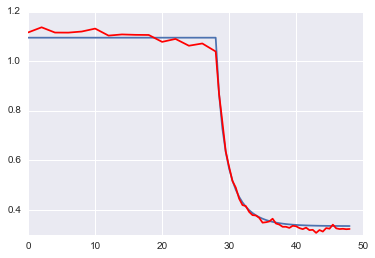

In [16]:
# using the estimated parameters, reproduce a simulated values and compare it to the experimental values.
ts_pre_inh = odeint(ode_mutant_model, [est_k_e, est_k_i], time_ee[time_ee<=t_inh_ee],  (estimated_k_v, est_k_i, est_k_e), rtol=1e-4)
ts_post_inh = odeint(ode_mutant_model, [est_k_e, est_k_i], time_ee[time_ee>t_inh_ee],  (estimated_k_v, est_k_i, h_ee[cell_id] * est_k_e), rtol=1e-4)

plt.plot(time_ee, np.concatenate(([i[0]/i[1] for i in ts_pre_inh], [i[0]/i[1] for i in ts_post_inh])))
plt.hold(True)
plt.plot(time_ee, first_cell, 'r');

Now we expand this for all the cells from this experiement. 

In [17]:
# Now run a simulation for all the cells in EE mutants.
param_ee_store = []

for cell, sc_h in zip(ee_ratio, h_ee):
    func = lambda x: ((calc_ts_sim_ratio(x, time_ee, estimated_k_v, t_inh_ee, sc_h) - cell[tidx])**2).sum()
    ret = minimize(func, x0=[np.mean(cell[:3]), 0.1], bounds=bnds, method='L-BFGS-B')
    param_ee_store.append(ret.x)
est_k_ip = [i[1] for i in param_ee_store]
est_k_ep = [i[0]*i[1] for i in param_ee_store]

print np.median(est_k_ep), np.median(est_k_ip)
print np.mean(est_k_ep), np.mean(est_k_ip)

0.19657957791 0.172213403263
0.205542543308 0.174910155797


Now run a simulation for all the cells in AA mutants.  
Parameter estimation for A mutants is more sensitive than EE mutants due to its small dynamic range.  
First, since it reaches to the steady state faster than EE mutant does, set t_end to 10.  

In [18]:
param_aa_store = []

time_aa = np.arange(0, 40) * 0.5 # /min, Imaged every 30 sec
t_inh_aa = 1.5   # /min, timing of inihibiton
t_start = None

tidx = time_aa >= t_start
time_aa = time_aa[tidx]

for cell, sc_h in zip(aa_ratio, h_aa):
    func = lambda x: ((calc_ts_sim_ratio(x, time_aa, estimated_k_v, t_inh_aa, sc_h) - cell[tidx])**2).sum()
    ret = minimize(func, x0=[np.mean(cell[:3]), 0.1], bounds=bnds)
    param_aa_store.append(ret.x)

est_k_eu = [i[0]*i[1] for i in param_aa_store]
est_k_iu = [i[1] for i in param_aa_store]

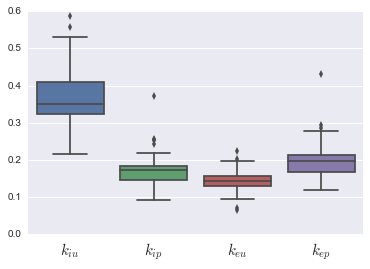

In [19]:
ax = sns.boxplot(data=[est_k_iu, est_k_ip, est_k_eu, est_k_ep])
ax.set_xticklabels(['$k_{iu}$', '$k_{ip}$', '$k_{eu}$', '$k_{ep}$'], fontsize=15);

You can see that the estimated import rate is larger in unphosphorylated reporters whereas the export rate is larger in phosphorylated reporters.  
The combination of these effects cause the cytoplasmic translocation of KTRs upon phosphorylation.

## Estimation of dephosphorylation parameters: k<sub>d</sub> and K<sub>md</sub>

k<sub>d</sub> and K<sub>md</sub> are the maximum dephosphorylation rate and Michaelis constant of reporter dephosphorylation, respectively. Here we assume k<sub>d</sub> is equal in both cytosol and nucleus.

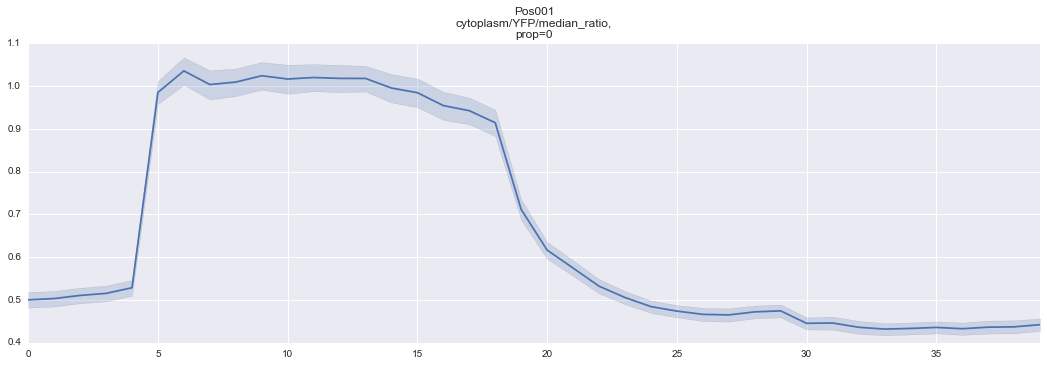

In [20]:
sites.staged.state = ['cytoplasm', 'YFP', 'median_ratio']
plot_tsplot = partial(ops_plotter.plot_tsplot)
fig, axes = sites.iterate(plot_tsplot)
site = sites.Pos001

In order to estimate $k_d$ and $K_{md}$, we fit the paremeters by simulating the model such that they reproduces the decay of C/N ratio after the kinase inhibitor treatment (after frame 18).  
We assume that JNK inhibitor decreases kinase activation instantly after the treatment and the extent of inhibition varies from cell to cell.  

We are going to use the average import/export rate constants estimated in the previous sections. Make a dictionary of parameter set.

In [21]:
# Define a parameter set from the previous analysis. 
param_set = dict(k_v=estimated_k_v, 
                 k_iu=np.nanmean(est_k_iu), k_eu=np.nanmean(est_k_eu), 
                 k_ip=np.nanmean(est_k_ip), k_ep=np.nanmean(est_k_ep),
                 k_cat=k_cat, Km=Km, r_total=r_total)

In [22]:
# param_set = {'Km': 3.0,
#  'k_cat': 20.0,
#  'k_ep': 0.19860127679563563,
#  'k_eu': 0.14376950245331685,
#  'k_ip': 0.18029311067217615,
#  'k_iu': 0.36616680751951008,
#  'k_v': 3.1609195402298851,
#  'r_total': 0.4}

Now make a model for KTR system describing the phosphorylation, dephosphorylation and nuclear-cytosolic shuttling of the KTR. 

FIXME: Write ODE in Latex

In [23]:
# Let's define the system with all of the parameters
def main_ode(y, t, p):
    """kin_c_func and kin_n_func are the functions that return the active kinase concentration at time t. 
    """
    c_u, n_u, c_p, n_p = y[0], y[1], y[2], y[3]

    k_v = p['k_v']
    k_iu, k_eu, k_ip, k_ep = p['k_iu'], p['k_eu'], p['k_ip'], p['k_ep']
    k_cat, Km, r_total = p['k_cat'], p['Km'], p['r_total']
    k_dc, k_dn, Kmd = p['k_d'], p['k_d'], p['Kmd']
    kin_c_func, kin_n_func = p['kin_c_func'], p['kin_n_func']

    d_c_u = -kin_c_func(t) * k_cat * c_u/(c_u + Km) + k_dc * c_p/(c_p + Kmd) - k_iu * c_u + k_eu * n_u
    d_n_u = -kin_n_func(t) * k_cat * n_u/(n_u + Km) + k_dn * n_p/(n_p + Kmd) + k_v * k_iu * c_u - k_v * k_eu * n_u
    d_c_p = kin_c_func(t) * k_cat * c_u/(c_u + Km) - k_dc * c_p/(c_p + Kmd) - k_ip * c_p + k_ep * n_p
    d_n_p = r_total - c_u - n_u/k_v - c_p - n_p/k_v
    return [d_c_u, d_n_u, d_c_p, d_n_p]


The system is in steady state before the inhibiton; at given C/N ratio, we calculate the reporter profile ($r_{cu}$, $r_{nu}$, $r_{cp}$, $r_{np}$) such that the $dr/dt$ becomes 0.

In [24]:
# Make a wrapper function to calculate reporter profile at steady state given active kinase concentration.
def calc_rep_profile_at_steady_state(kin, pset):
    """At given kinase concentration and parameters,
    simulate the reporter profile (c_u, n_u, c_p, c_p)
    such that it minimizes sum of squared dy, assuming the pseudo-steady state.
    
    Output: reporter profile, 
    """
    ub = pset['r_total']
    pset['kin_c_func'] = lambda t: np.interp(t, [0, 1], [float(kin), float(kin)])
    pset['kin_n_func'] = lambda t: np.interp(t, [0, 1], [float(kin), float(kin)])
    x0 = [ub, 0, 0, 0]

    func = lambda y: (np.array(main_ode(y, 0, pset))**2).sum()
    ret = minimize(func, x0=x0, method='Powell', tol=1e-3)
    return ret.x

def calc_rcn_at_steady_state(kin, pset):
    """At given kinase concentration and parameters, simulate the C/N ratio
    such that it minimizes sum of squared dy, assuming the pseudo-steady state.
    """
    x = calc_rep_profile_at_steady_state(kin, pset)
    return (x[0] + x[2])/(x[1] + x[3])

In [25]:
KIN_MAX = 3.0
def inhibitor_ode(x, time, rcn_init, rcn_final, pset):
    pset['k_d'] = x[0]
    pset['Kmd'] = x[1]
    # Calculate kinase concentration at steady state such that it matches with given rcn
    func1 = lambda kin1: ((calc_rcn_at_steady_state(kin1, pset) - rcn_init)**2).sum()
    ret1 = minimize(func1, x0=[0.01], bounds=((0, KIN_MAX), ), tol=1e-3)
    # At given kinase concentration, calculate reporter profile.
    kin_ini = ret1.x[0]
    y0 = calc_rep_profile_at_steady_state(kin_ini, pset)
    # At given rcn_final, calculate kinase concentration at the final steady state.
    func2 = lambda kin2: ((calc_rcn_at_steady_state(kin2, pset) - rcn_final)**2).sum()
    ret = minimize(func2, x0=[0.01], bounds=((0, kin_ini), ), tol=1e-3)

    kin_after_inh = ret.x[0]
    pset['kin_c_func'] = lambda t: np.interp(t, [time[0], time[-1]], [kin_after_inh, kin_after_inh])
    pset['kin_n_func'] = lambda t: np.interp(t, [time[0], time[-1]], [kin_after_inh, kin_after_inh])
    # At time 0, inihibition started. kinase is inactive so it follows kinase (rcn_final)
    # but reporter profile at time 0 follows y0. Calculate cytoplasmic to nuclear times series.
    ts = odeint(main_ode, y0, time, (pset, ), rtol=1e-3)
    return (ts[:, 0] + ts[:, 2])/(ts[:, 1] + ts[:, 3])

Let's estimate $k_d$ and $K_{md}$ for a single cell to begin with.  
This fitting problem is tricky, so we will first simulate fitting to guess the initial values by looping over some parameter range.  
Note that we bound the upper limit of $K_{md}$ as $r_{total}$.

In [42]:
# Let's calcualte this for a single cell first. 
single_rcn = site.data['cytoplasm', 'YFP', 'median_ratio'][1, 18:33]
time = np.arange(len(single_rcn)) * 5  # every 5 min
func = lambda x: ((inhibitor_ode(x, time, single_rcn[0], single_rcn[-1], param_set) - single_rcn)**2).sum()  # cost function

# To avoid trapped in local solution, we will first estimate initial values by looping over in a log-scale.
kd_range, kmd_range = np.logspace(-2, 0, 5), np.logspace(-2, np.log10(param_set['r_total']), 5)
store = [np.Inf, np.Inf, np.Inf]
for kdi in kd_range:
    for kmdi in kmd_range:
        res = ((inhibitor_ode([kdi, kmdi], time, single_rcn[0],single_rcn[-1], param_set) - single_rcn)**2).sum()
        if store[0] > res:
            store = [res, kdi, kmdi]
ini_kd, ini_kmd = store[1], store[2]

Now we estimate $k_d$ and $K_{md}$ using the initial values estimated. 

In [43]:
cons = ({'type': 'ineq', 'fun': lambda x: x[0]},
        {'type': 'ineq', 'fun': lambda x: x[1]},
        {'type': 'ineq', 'fun': lambda x: 3.0 - x[0]},
        {'type': 'ineq', 'fun': lambda x: param_set['r_total'] - x[1]})
ret = minimize(func, x0=[ini_kd, ini_kmd], constraints=cons, method='COBYLA', tol=1e-4)
print 'The estimated k_d and Kmd for this cell is {0:1.3f} and {1:1.3f}'.format(*ret.x)

The estimated k_d and Kmd for this cell is 0.032 and 0.010


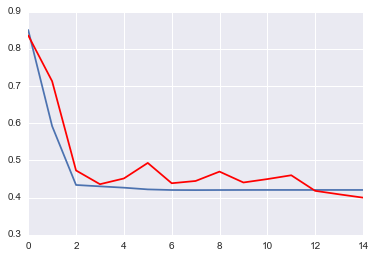

In [44]:
# Reproduce the simulate time course given estimated parameters.
plt.plot(inhibitor_ode([ret.x[0], ret.x[1]], time, single_rcn[0], single_rcn[-1], param_set))
plt.hold(True)
plt.plot(single_rcn, 'r')

Now we will estimate $k_d$ and $K_{md}$ for all the cells.  
To save a time for demonstration, here we just take the median time-course and run a fitting againt it.  

The estimated k_d and Kmd for this cell is 0.032 and 0.010


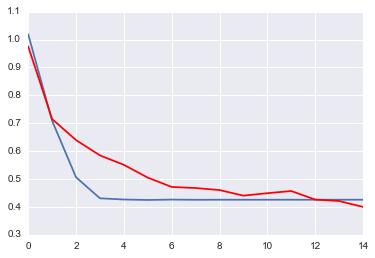

In [45]:
# The estimation of k_d and Kmd for all the single cells takes a time.
med_rcn = np.nanmedian(site.data['cytoplasm', 'YFP', 'median_ratio'][:, 18:33], axis=0)
func = lambda x: ((inhibitor_ode(x, time, med_rcn[0], med_rcn[-1], param_set) - med_rcn)**2).sum()
cons = ({'type': 'ineq', 'fun': lambda x: x[0]},
        {'type': 'ineq', 'fun': lambda x: x[1]},
        {'type': 'ineq', 'fun': lambda x: 3.0 - x[0]},
        {'type': 'ineq', 'fun': lambda x: param_set['r_total'] - x[1]})
ret = minimize(func, x0=[ini_kd, ini_kmd], constraints=cons, method='COBYLA', tol=1e-4)
est_k_d, est_Kmd = ret.x[0], ret.x[1]

plt.plot(inhibitor_ode([est_k_d, est_Kmd], time, med_rcn[0], med_rcn[-1], param_set))
plt.hold(True)
plt.plot(med_rcn, 'r')
print 'The estimated k_d and Kmd for this cell is {0:1.3f} and {1:1.3f}'.format(est_k_d, est_Kmd)

In [46]:
# # If you want to estimate for all the single cells, then use this cell.
# k_d_store, Kmd_store = [], []
# for num, rcn in enumerate(site.data['cytoplasm', 'YFP', 'median_ratio'][:, 18:33]):
#     print "calculating for {0}th cell".format(num)
#     func = lambda x: ((inhibitor_ode(x, time, rcn[0], rcn[-1], param_set) - rcn)**2).sum()
#     cons = ({'type': 'ineq', 'fun': lambda x: x[0]},
#             {'type': 'ineq', 'fun': lambda x: x[1]},
#             {'type': 'ineq', 'fun': lambda x: 3.0 - x[0]},
#             {'type': 'ineq', 'fun': lambda x: param_set['r_total'] - x[1]})
#     ret = minimize(func, x0=[ini_kd, ini_kmd], constraints=cons, method='COBYLA', tol=1e-4)
#     k_d_store.append(ret.x[0])
#     Kmd_store.append(ret.x[1])

## Absolute kinase concentration

Now we obtained the all of the parameters we need to estimate absolute kinase concentration over time. 
Let's calculate the time-course of active JNK with IL1B treatment. 

In [31]:
parent_folder = join(data_folder, 'IL1B')
sub_folders = ['Pos005', 'Pos006', 'Pos007', 'Pos008']
conditions = ['IL1B', 'IL1B', 'IL1B', 'IL1B']
sites_il1b = Sites(parent_folder, sub_folders, conditions, file_name='df_cleaned.npz')
sites_il1b.staged.new_file_name = 'merged.npz'
sites_il1b.merge_conditions()

Pos005: file_name is updated to merged.npz


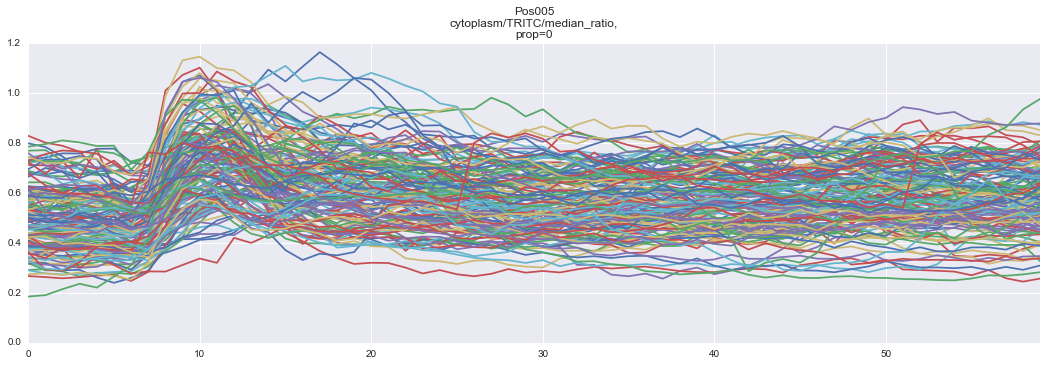

In [32]:
sites_il1b.set_state(['cytoplasm', 'TRITC', 'median_ratio'])
plot_all = partial(ops_plotter.plot_all)
fig, axes = sites_il1b.iterate(plot_all)

In this experiment, cells express the JNK KTR AE mutant (right) in addition to the JNK KTR (left).  
The variability you observed in the JNK KTR AE mutant is reflection of the noise of export and import rate. We can correct for the variability in import and export in individual cells using the information from JNK KTR AE mutant.  
For each cells, we calculate the average C/N ratio over time and then divide it by population level C/N ratio; this is *q*, the noise factor in export/import.  
We correct the mean value of the estimated $k_e$ and $k_i$ using $q$ for each cells. 

In [33]:
mean_yfp = np.mean(sites_il1b.Pos005.data['cytoplasm', 'YFP', 'median_ratio'], axis=0)
q_store = []
for cell in sites_il1b.Pos005.data['cytoplasm', 'YFP', 'median_ratio']:
    q_store.append(np.mean(cell/mean_yfp))

k_iu_sc, k_ip_sc, k_eu_sc, k_ep_sc = [], [], [], []
for q in q_store:
    k_iu_sc.append(np.nanmean(est_k_iu)/q)
    k_ip_sc.append(np.nanmean(est_k_ip)/q)
    k_eu_sc.append(np.nanmean(est_k_eu) * q)
    k_ep_sc.append(np.nanmean(est_k_ep) * q) 

Now let's start from a single cell.

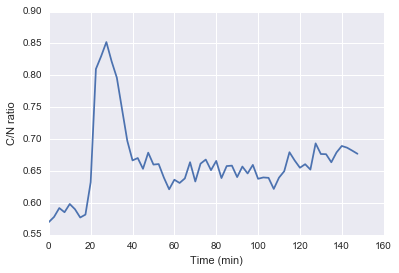

In [55]:
cell_id = 1
time = np.arange(0, 150, 2.5)  # in minute
single_rcn = sites_il1b.Pos005.data['cytoplasm', 'TRITC', 'median_ratio'][cell_id, :]
plt.plot(time, single_rcn)
plt.ylabel('C/N ratio')
plt.xlabel('Time (min)')

First, to reduce the complexity of parameter estimation, we assume that time-course of active JNK with IL1B treatment can be mimicked with the trapezoid function like below. (CITATION)
<img src="../../data/trapezoid.jpg" width="300">

Given a pulsatile time-series, the function *fit_trapezoid* will return seven parameters required to define the trapezoid function; t1, t2, t3, t4, c1, c2 and c3.

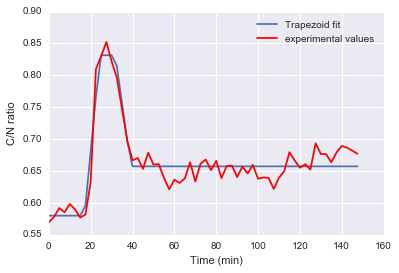

In [69]:
t1, t2, t3, t4, c1, c2, c3 = fit_trapezoid(time, single_rcn)
kin_func = lambda t: np.interp(t, [t1, t2, t3, t4, time[-1]], [c1, c2, c2, c3, c3])
plt.plot(time, kin_func(time))
plt.hold(True)
plt.plot(time, single_rcn, 'r')
plt.legend(['Trapezoid fit', 'experimental values'])
plt.ylabel('C/N ratio')
plt.xlabel('Time (min)')

In [73]:
# Set the corrected import and export rate constants for this cell to the param_set.
param_set['k_iu'] = k_iu_sc[cell_id]
param_set['k_ip'] = k_ip_sc[cell_id]
param_set['k_eu'] = k_eu_sc[cell_id]
param_set['k_ep'] = k_ep_sc[cell_id]

In [74]:
# Define kin_c_func and kin_n_func which returns the active kinase concentration at given time. 
# Note that we do not distinguish localizations of the reporters since it does not have a huge effects under our estimates of the import/export.
param_set['kin_c_func'] = kin_func
param_set['kin_n_func'] = kin_func
param_set['k_d'] = est_k_d
param_set['Kmd'] = est_Kmd

In [75]:
def kinase_dynamics_ode(kins, time, pset, t1, t2, t3, t4):
    """receives kinase concentration corresponding to C1, C2 and C3 and run a simulation based on those."""
    k1, k2, k3 = kins
    # get model to steady state
    rep0 = calc_rep_profile_at_steady_state(k1, pset)
    pset['kin_c_func'] = lambda t: np.interp(t, [t1, t2, t3, t4, time[-1]], [k1, k2, k2, k3, k3])
    pset['kin_n_func'] = lambda t: np.interp(t, [t1, t2, t3, t4, time[-1]], [k1, k2, k2, k3, k3])
    ts = odeint(main_ode, rep0, time, (pset, ), rtol=1e-3)
    return ts

def rcn_dynamics_ode(kins, time, pset, t1, t2, t3, t4):
    rep = kinase_dynamics_ode(kins, time, pset, t1, t2, t3, t4)
    return (rep[:, 0] + rep[:, 2])/(rep[:, 1] + rep[:, 3])

In [76]:
kin_max=1

In [77]:
func = lambda x: ((rcn_dynamics_ode(x, time, param_set, t1, t2, t3, t4) - kin_func(time))**2).sum()
bnds = ((0, kin_max),) * 3
cons = ({'type': 'ineq', 'fun': lambda x: x[0]},
        {'type': 'ineq', 'fun': lambda x: x[1]},
        {'type': 'ineq', 'fun': lambda x: x[2]},
        {'type': 'ineq', 'fun': lambda x: x[1] - x[0]-0.1},
        {'type': 'ineq', 'fun': lambda x: x[1] - x[2]-0.1})        
# ret = minimize(func, x0=(kin_max/3, kin_max, kin_max/2), constraints=cons, bounds=bnds, method='L-BFGS-B')
ret = minimize(func, x0=(kin_max/3, kin_max, kin_max/2), constraints=cons, method='COBYLA')

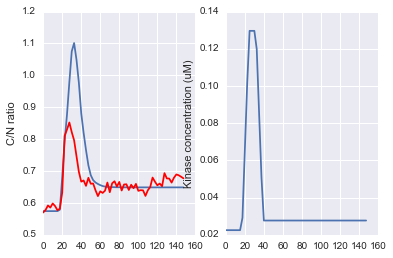

In [78]:
ax1 = plt.subplot(1,2,1)
h1 = plt.plot(time, rcn_dynamics_ode(ret.x, time, param_set, t1, t2, t3, t4))
plt.hold(True)
h2 = plt.plot(time, single_rcn, 'r')
ax1.set_ylabel('C/N ratio')

ax2 = plt.subplot(1,2,2)
kin_ts = np.interp(time, [t1, t2, t3, t4, time[-1]], [ret.x[0], ret.x[1], ret.x[1], ret.x[2], ret.x[2]])
plt.plot(time, kin_ts)
ax2.set_ylabel('Kinase concentration (uM)')

In [ ]:
def kinase_dynamics_ode(kins, time, pset, t1, t2, t3, t4):
    """receives kinase concentration corresponding to C1, C2 and C3 and run a simulation based on those."""
    k1, k2, k3 = kins
    # get model to steady state
    rep0 = calc_rep_profile_at_steady_state(k1, pset)
    pset['kin_c_func'] = lambda t: np.interp(t, [t1, t2, t3, t4, time[-1]], [k1, k2, k2, k3, k3])
    pset['kin_n_func'] = lambda t: np.interp(t, [t1, t2, t3, t4, time[-1]], [k1, k2, k2, k3, k3])
    ts = odeint(main_ode, rep0, time, (pset, ), rtol=1e-3)
    return ts

def rcn_dynamics_ode(kins, time, pset, t1, t2, t3, t4):
    rep = kinase_dynamics_ode(kins, time, pset, t1, t2, t3, t4)
    return (rep[:, 0] + rep[:, 2])/(rep[:, 1] + rep[:, 3])

In [99]:
def estim_steady_state_kinase(rcn_ini, pset):
    func1 = lambda kin1: ((calc_rcn_at_steady_state(kin1, pset) - rcn_ini)**2).sum()
    ret1 = minimize(func1, x0=[0.01], bounds=((0, KIN_MAX), ), tol=1e-3)
    return ret1.x[0]


def kinase_dynamics_ode2(kins, time, pset, k1, t1, t2, t3, t4):
    """receives kinase concentration corresponding to C1, C2 and C3 and run a simulation based on those."""
    k2, k3 = kins
    # get model to steady state
    rep0 = calc_rep_profile_at_steady_state(k1, pset)
    pset['kin_c_func'] = lambda t: np.interp(t, [t1, t2, t3, t4, time[-1]], [k1, k2, k2, k3, k3])
    pset['kin_n_func'] = lambda t: np.interp(t, [t1, t2, t3, t4, time[-1]], [k1, k2, k2, k3, k3])
    ts = odeint(main_ode, rep0, time, (pset, ), rtol=1e-3)
    return ts

def rcn_dynamics_ode2(kins, time, pset, k1, t1, t2, t3, t4):
    rep = kinase_dynamics_ode2(kins, time, pset, k1, t1, t2, t3, t4)
    return (rep[:, 0] + rep[:, 2])/(rep[:, 1] + rep[:, 3])

kin_ini = estim_steady_state_kinase(c1, param_set)

In [102]:
func = lambda x: ((rcn_dynamics_ode2(x, time, param_set, kin_ini, t1, t2, t3, t4) - kin_func(time))**2).sum()
bnds = ((0, kin_max),) * 3
cons = ({'type': 'ineq', 'fun': lambda x: x[0]},
        {'type': 'ineq', 'fun': lambda x: x[1]},
        {'type': 'ineq', 'fun': lambda x: x[0] - x[1]})
# ret = minimize(func, x0=(kin_max/3, kin_max, kin_max/2), constraints=cons, bounds=bnds, method='L-BFGS-B')
ret = minimize(func, x0=(kin_ini*3, kin_ini*2), constraints=cons, method='COBYLA')


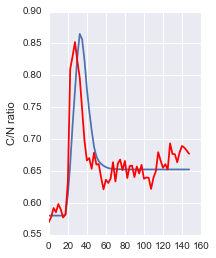

In [108]:

ax1 = plt.subplot(1,2,1)
h1 = plt.plot(time, rcn_dynamics_ode2(ret.x, time, param_set, kin_ini, t1, t2, t3, t4))
plt.hold(True)
h2 = plt.plot(time, single_rcn, 'r')
ax1.set_ylabel('C/N ratio')

ax2 = plt.subplot(1,2,2)
kin_ts = np.interp(time, [t1, t2, t3, t4, time[-1]], [ret.x[0], ret.x[0], ret.x[0], ret.x[1], ret.x[2]])
plt.plot(time, kin_ts)
ax2.set_ylabel('Kinase concentration (uM)')